## **Boids 🦜🐟**

### **Importações**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.widgets import Slider

%matplotlib widget

plt.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "font.size": 12 
})

### **Configurações Iniciais**

In [2]:
CONFIG = {
    "N_PRESAS": 500,
    "N_PREDADORES": 2,
    "WIDTH": 100,
    "HEIGHT": 100,
}

parametros = {
    "width": CONFIG["WIDTH"],
    "height": CONFIG["HEIGHT"],
    "dt": 0.5,
    
    "max_velocidade_presa": 3,
    "max_velocidade_pred": 2,
    
    "peso_coesao": 1.0,        
    "peso_alinhamento": 1.0,
    "peso_separacao": 1.5,
    
    "peso_fuga": 2.4,        
    "peso_perseguicao": 0.7, 
    "peso_separacao_pred": 0.5,
    
    "raio_percepcao_presa": 10.0,
    "raio_percepcao_predador": 15.0,    
    "raio_barreira": 10.0,    
    "forca_barreira": 0.8,   
}

### **Função para Inicializar as Posições e Velocidades**

In [3]:
def init_simulation(config, params):
    """Inicializa as posições e velocidades dos agentes."""
    np.random.seed(404)

    w, h = config["WIDTH"], config["HEIGHT"]
    
    presas_pos = np.random.rand(config["N_PRESAS"], 2) * np.array([w, h])
    presas_vel = (np.random.rand(config["N_PRESAS"], 2) - 0.5) * params["max_velocidade_presa"]

    preds_pos = np.random.rand(config["N_PREDADORES"], 2) * np.array([w, h])
    preds_vel = (np.random.rand(config["N_PREDADORES"], 2) - 0.5) * params["max_velocidade_pred"]
    
    return presas_pos, presas_vel, preds_pos, preds_vel

presas_pos, presas_vel, preds_pos, preds_vel = init_simulation(CONFIG, parametros)

### **Função dos Cálculos**

In [4]:
def aplicar_restricoes(pos, vel, params, tipo):
    """
    Aplica penalidade por multidão, limites de velocidade, ruído e paredes.
    """
    L_x, L_y = params["width"], params["height"]
    
    
    if tipo == "presa":
        velocidade_maxima = params["max_velocidade_presa"]
        
        # Multidão
        diferenca = pos[:, None] - pos
        distancias = np.linalg.norm(diferenca, axis=2)
        np.fill_diagonal(distancias, np.inf) # Ignora a si mesmo
        
        num_vizinhos = np.sum(distancias < params["raio_percepcao_presa"], axis=1)
        
        limite_multidao = 0.2 * len(pos)
        mask_multidao = num_vizinhos > limite_multidao
        vel[mask_multidao] *= 0.9
        
    else: 
        velocidade_maxima = params["max_velocidade_pred"]
    
    # Ruído
    ruido_max = 0.2
    angulos = np.random.uniform(-ruido_max, ruido_max, size=len(vel))
    c, s = np.cos(angulos), np.sin(angulos)
    
    vel_x_new = vel[:, 0] * c - vel[:, 1] * s
    vel_y_new = vel[:, 0] * s + vel[:, 1] * c
    vel[:, 0], vel[:, 1] = vel_x_new, vel_y_new
    
    # Limete de velocidade
    speed = np.linalg.norm(vel, axis=1)
    mask_limit = speed > velocidade_maxima
    vel[mask_limit] = (vel[mask_limit] / (speed[mask_limit][:, None] + 1e-8)) * velocidade_maxima
    
    # Paredes
    pos[:, 0] = np.clip(pos[:, 0], 0, L_x)
    pos[:, 1] = np.clip(pos[:, 1], 0, L_y)

    return pos, vel

In [5]:
def calcular_deltas(pos_presas, vel_presas, pos_predadores, vel_predadores, params):
    n_presas = len(pos_presas)
    n_predadores = len(pos_predadores)
    L_x, L_y = params["width"], params["height"]
    
    # Distâncias (Presa-Presa)
    diferenca_presas = pos_presas[:, None] - pos_presas
    distancias_presas = np.linalg.norm(diferenca_presas, axis=2)
    np.fill_diagonal(distancias_presas, np.inf)
    
    vizinhos_presas = (distancias_presas < params["raio_percepcao_presa"])

    # Vetores de velocidade
    v_coesao = np.zeros((n_presas, 2))
    v_alinhamento = np.zeros((n_presas, 2))
    v_separacao = np.zeros((n_presas, 2))
    v_fuga = np.zeros((n_presas, 2))
    v_barreira = np.zeros((n_presas, 2))
    v_barreira_pred = np.zeros((n_predadores, 2))

    # Fuga
    diferenca_predadores = pos_presas[:, None] - pos_predadores
    distancia_predadores = np.linalg.norm(diferenca_predadores, axis=2)
    
    mask_perigo = distancia_predadores < params["raio_percepcao_predador"]
    if np.any(mask_perigo):

        predador_mais_prox_idx = np.argmin(distancia_predadores, axis=1)
        presas_em_perigo = np.any(mask_perigo, axis=1)
        
        if np.any(presas_em_perigo):
            idx_p = predador_mais_prox_idx[presas_em_perigo]
            diffs = diferenca_predadores[presas_em_perigo, idx_p]
            dists = distancia_predadores[presas_em_perigo, idx_p]
            v_fuga[presas_em_perigo] = diffs / (dists[:, None] + 1e-5)**1.5

    # Regras dos Boids
    contagem = vizinhos_presas.sum(axis=1)[:, None] + 1e-8
    tem_vizinhos = contagem.flatten() > 1e-5

    if np.any(tem_vizinhos):
        # Coesão
        soma_pos = np.dot(vizinhos_presas, pos_presas)
        v_coesao[tem_vizinhos] = (soma_pos[tem_vizinhos] / contagem[tem_vizinhos]) - pos_presas[tem_vizinhos]
        
        # Alinhamento
        soma_vel = np.dot(vizinhos_presas, vel_presas)
        v_alinhamento[tem_vizinhos] = (soma_vel[tem_vizinhos] / contagem[tem_vizinhos]) - vel_presas[tem_vizinhos]

    # Separação
    for i in np.where(tem_vizinhos)[0]:
        mask = vizinhos_presas[i]
        v_separacao[i] = np.sum((pos_presas[i] - pos_presas[mask]) / (distancias_presas[i, mask][:, None] + 1e-5)**2, axis=0)

    # Barreiras
    E, A = params["raio_barreira"], params["forca_barreira"]
    
    # Presas
    v_barreira[:, 0] = A * np.exp(-(pos_presas[:, 0]/E)**2) - A * np.exp(-((pos_presas[:, 0]-L_x)/E)**2)
    v_barreira[:, 1] = A * np.exp(-(pos_presas[:, 1]/E)**2) - A * np.exp(-((pos_presas[:, 1]-L_y)/E)**2)
    
    # Predadores
    v_barreira_pred[:, 0] = A * np.exp(-(pos_predadores[:, 0]/E)**2) - A * np.exp(-((pos_predadores[:, 0]-L_x)/E)**2)
    v_barreira_pred[:, 1] = A * np.exp(-(pos_predadores[:, 1]/E)**2) - A * np.exp(-((pos_predadores[:, 1]-L_y)/E)**2)

    # dV Presas
    dv_presas = (v_coesao * params["peso_coesao"] + 
                 v_alinhamento * params["peso_alinhamento"] + 
                 v_separacao * params["peso_separacao"] +
                 v_fuga * params["peso_fuga"] + 
                 v_barreira)

    # dv Predadores
    dv_predadores = v_barreira_pred.copy()
    
    if n_presas > 0:
        dists_p = distancia_predadores.T
        alvo_idx = np.argmin(dists_p, axis=1)
        direcao = pos_presas[alvo_idx] - pos_predadores
        norma = np.linalg.norm(direcao, axis=1, keepdims=True)
        dv_predadores += (direcao / (norma + 1e-5)) * params["peso_perseguicao"]

    # Repulsão (Predador - Predador)
    if n_predadores > 1:
        diff_p = pos_predadores[:, None] - pos_predadores
        dist_p = np.linalg.norm(diff_p, axis=2)
        np.fill_diagonal(dist_p, np.inf)
        
        mask_p = dist_p < params["raio_percepcao_predador"]
        for j in range(n_predadores):
            if np.any(mask_p[j]):
                afastamento = np.sum((pos_predadores[j] - pos_predadores[mask_p[j]]) / (dist_p[j, mask_p[j]][:, None] + 1e-5), axis=0)
                dv_predadores[j] += afastamento * params["peso_separacao_pred"]

    return dv_presas, dv_predadores

In [6]:
def update_boids(pos_presas, vel_presas, pos_preds, vel_preds, params, metodo="rk4"):
    dt = params["dt"]

    if metodo == "rk4": # Runge Kutta 4
        # k1
        acc_presas_k1, acc_preds_k1 = calcular_deltas(pos_presas, vel_presas, pos_preds, vel_preds, params)
        
        # k2
        p_k2_pr = pos_presas + vel_presas * 0.5 * dt
        v_k2_pr = vel_presas + acc_presas_k1 * 0.5 * dt
        p_k2_pd = pos_preds + vel_preds * 0.5 * dt
        v_k2_pd = vel_preds + acc_preds_k1 * 0.5 * dt
        acc_presas_k2, acc_preds_k2 = calcular_deltas(p_k2_pr, v_k2_pr, p_k2_pd, v_k2_pd, params)
        
        # k3
        p_k3_pr = pos_presas + v_k2_pr * 0.5 * dt
        v_k3_pr = vel_presas + acc_presas_k2 * 0.5 * dt
        p_k3_pd = pos_preds + v_k2_pd * 0.5 * dt
        v_k3_pd = vel_preds + acc_preds_k2 * 0.5 * dt
        acc_presas_k3, acc_preds_k3 = calcular_deltas(p_k3_pr, v_k3_pr, p_k3_pd, v_k3_pd, params)
        
        # k4
        p_k4_pr = pos_presas + v_k3_pr * dt
        v_k4_pr = vel_presas + acc_presas_k3 * dt
        p_k4_pd = pos_preds + v_k3_pd * dt
        v_k4_pd = vel_preds + acc_preds_k3 * dt
        acc_presas_k4, acc_preds_k4 = calcular_deltas(p_k4_pr, v_k4_pr, p_k4_pd, v_k4_pd, params)
        
        # Soma Final
        pos_presas += (dt/6.0) * (vel_presas + 2*v_k2_pr + 2*v_k3_pr + v_k4_pr)
        vel_presas += (dt/6.0) * (acc_presas_k1 + 2*acc_presas_k2 + 2*acc_presas_k3 + acc_presas_k4)
        
        pos_preds += (dt/6.0) * (vel_preds + 2*v_k2_pd + 2*v_k3_pd + v_k4_pd)
        vel_preds += (dt/6.0) * (acc_preds_k1 + 2*acc_preds_k2 + 2*acc_preds_k3 + acc_preds_k4)

    else: # Euler
        acc_presas, acc_preds = calcular_deltas(pos_presas, vel_presas, pos_preds, vel_preds, params)
        
        pos_presas += vel_presas * dt
        vel_presas += acc_presas * dt
        
        pos_preds += vel_preds * dt
        vel_preds += acc_preds * dt

    # Restrições
    pos_presas, vel_presas = aplicar_restricoes(pos_presas, vel_presas, params, tipo="presa")
    pos_preds, vel_preds = aplicar_restricoes(pos_preds, vel_preds, params, tipo="predador")

    return pos_presas, vel_presas, pos_preds, vel_preds

### **Visualização - Configurações do Matplotlib**


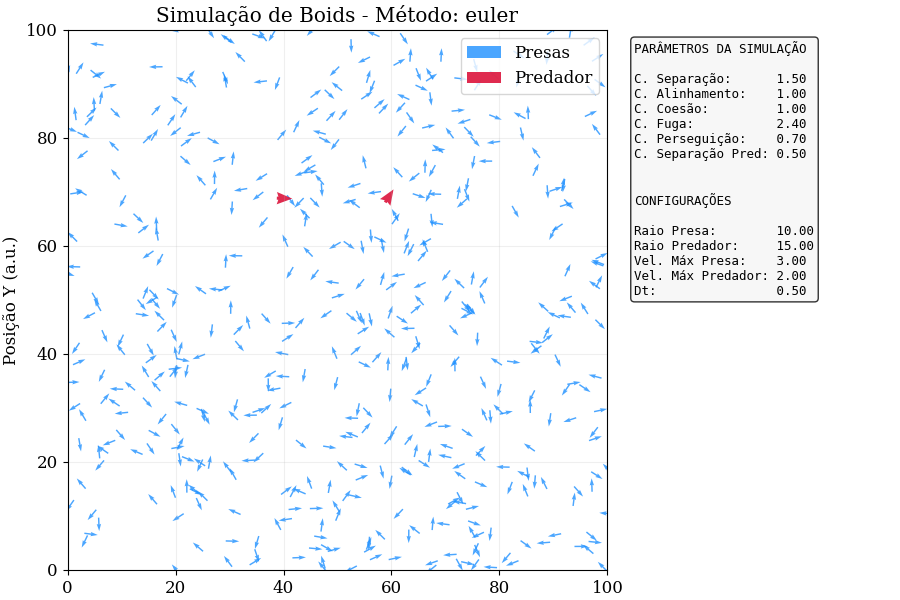

In [7]:
try:
    anim.event_source.stop()
except NameError:
    pass
plt.close("all")

TOTAL_PASSOS = 2500 
METODO = "euler"

fig, ax = plt.subplots(figsize=(9, 6))
fig.canvas.header_visible = False  

plt.subplots_adjust(left=0.05, bottom=0.05, right=0.70, top=0.95)

ax.set_xlim(0, parametros["width"])
ax.set_ylim(0, parametros["height"])
ax.set_ylabel("Posição Y (a.u.)")
ax.set_xlabel("Posição X (a.u.)")
ax.set_title(f"Simulação de Boids - Método: {METODO}")
ax.set_aspect("equal") 
ax.grid(True, alpha=0.2)

time_text = ax.text(0.02, 0.95, "", transform=ax.transAxes, 
                    bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"))

info_text = (
    "PARÂMETROS DA SIMULAÇÃO\n\n"

    f"C. Separação:      {parametros["peso_separacao"]:.2f}\n"
    f"C. Alinhamento:    {parametros["peso_alinhamento"]:.2f}\n"
    f"C. Coesão:         {parametros["peso_coesao"]:.2f}\n"
    f"C. Fuga:           {parametros["peso_fuga"]:.2f}\n"
    f"C. Perseguição:    {parametros["peso_perseguicao"]:.2f}\n"
    f"C. Separação Pred: {parametros["peso_separacao_pred"]:.2f}\n\n"

    "\nCONFIGURAÇÕES\n\n"
    f"Raio Presa:        {parametros["raio_percepcao_presa"]:.2f}\n"
    f"Raio Predador:     {parametros["raio_percepcao_predador"]:.2f}\n"
    f"Vel. Máx Presa:    {parametros["max_velocidade_presa"]:.2f}\n"
    f"Vel. Máx Predador: {parametros["max_velocidade_pred"]:.2f}\n"
    f"Dt:                {parametros["dt"]:.2f}"
)

ax.text(1.05, 0.98, info_text, transform=ax.transAxes, fontsize=9,
        verticalalignment="top", fontfamily="monospace",
        bbox=dict(boxstyle="round", facecolor="whitesmoke", alpha=0.8))

# --- 2. Inicialização dos Objetos Gráficos (Setas) ---
def normalizar_para_plot(vel):
    """Normaliza vetores apenas para visualização (tamanho fixo das setas)"""
    norm = np.linalg.norm(vel, axis=1)
    return np.divide(vel, norm[:, None] + 1e-8)

# Setas das Presas (Azul)
vel_norm_init = normalizar_para_plot(presas_vel)
quiver_presas = ax.quiver(
    presas_pos[:, 0], presas_pos[:, 1], 
    vel_norm_init[:, 0], vel_norm_init[:, 1], 
    color="dodgerblue", pivot="mid", scale=40, headwidth=3, alpha=0.8, label="Presas"
)

# Setas dos Predadores (Vermelho)
vel_norm_p = normalizar_para_plot(preds_vel)
quiver_preds = ax.quiver(
    preds_pos[:, 0], preds_pos[:, 1], 
    vel_norm_p[:, 0], vel_norm_p[:, 1], 
    color="crimson", pivot="mid", scale=35, headwidth=4, label="Predador", alpha=0.9
)
ax.legend(loc="upper right", framealpha=0.8)

# --- 4. Loop de Animação ---
tempo_simulacao = 0.0

# Reinicia posições caso a célula seja rodada novamente 
presas_pos, presas_vel, preds_pos, preds_vel = init_simulation(CONFIG, parametros)

def animate(frame):
    global presas_pos, presas_vel, preds_pos, preds_vel, tempo_simulacao
    

    presas_pos, presas_vel, preds_pos, preds_vel = update_boids(
        presas_pos, presas_vel, preds_pos, preds_vel, 
        parametros, metodo=METODO
    )
    
    tempo_simulacao += parametros["dt"]

    quiver_presas.set_offsets(presas_pos)
    v_norm = normalizar_para_plot(presas_vel)
    quiver_presas.set_UVC(v_norm[:, 0], v_norm[:, 1])

    quiver_preds.set_offsets(preds_pos)
    vp_norm = normalizar_para_plot(preds_vel)
    quiver_preds.set_UVC(vp_norm[:, 0], vp_norm[:, 1])
    
    time_text.set_text(f"Passo: {frame} | Tempo: {tempo_simulacao:.1f}s | {METODO}" )

    return quiver_presas, quiver_preds, time_text

# Iniciar
anim = FuncAnimation(fig, animate, frames=TOTAL_PASSOS, interval=100, blit=True, repeat=False)
plt.show()

### **Salvando vídeo da simulação**

In [8]:
anim.save(f"simulacao_boids_{METODO}_0144.gif", writer="pillow", fps=30, dpi=100)

print("GIF salvo!")

GIF salvo!


### **Plotagem dos Gráficos**

In [9]:
presas_pos, presas_vel, preds_pos, preds_vel = init_simulation(CONFIG, parametros)
historico_boid_euler = []
idx_rastreio = 0

PASSOS_TRAJETORIA = 500

for _ in range(PASSOS_TRAJETORIA):
    historico_boid_euler.append(presas_pos[idx_rastreio].copy())
    
    presas_pos, presas_vel, preds_pos, preds_vel = update_boids(
        presas_pos, presas_vel, preds_pos, preds_vel, 
        parametros, metodo="euler"
    )

trajetoria_euler = np.array(historico_boid_euler)

In [10]:
presas_pos, presas_vel, preds_pos, preds_vel = init_simulation(CONFIG, parametros)
historico_boid_rk4 = []
idx_rastreio = 0

for _ in range(PASSOS_TRAJETORIA):
    historico_boid_rk4.append(presas_pos[idx_rastreio].copy())
    
    presas_pos, presas_vel, preds_pos, preds_vel = update_boids(
        presas_pos, presas_vel, preds_pos, preds_vel, 
        parametros, metodo="rk4"
    )

trajetoria_rk4 = np.array(historico_boid_rk4)

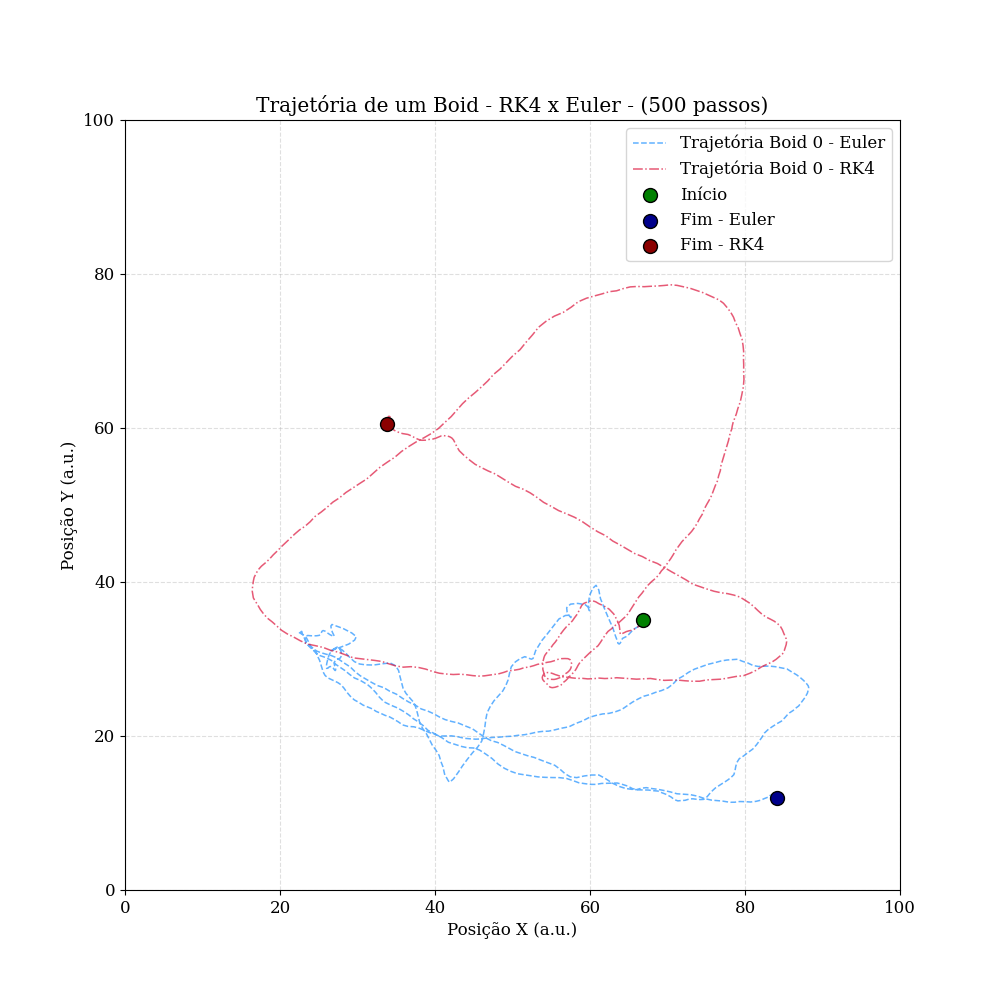

In [ ]:
plt.figure(figsize=(10, 10), dpi=100)
plt.plot(trajetoria_euler[:, 0], trajetoria_euler[:, 1], label=f"Trajetória Boid {idx_rastreio} - Euler", 
         color="dodgerblue", linewidth=1.1, alpha=0.7, linestyle="--")
plt.plot(trajetoria_rk4[:, 0], trajetoria_rk4[:, 1], label=f"Trajetória Boid {idx_rastreio} - RK4", 
         color="crimson", linewidth=1.1, alpha=0.7, linestyle="-.")


plt.scatter(trajetoria_euler[0, 0], trajetoria_euler[0, 1], c="green", s=100, label="Início", edgecolors="black", zorder=5)

plt.scatter(trajetoria_euler[-1, 0], trajetoria_euler[-1, 1], c="darkblue", s=100, label="Fim - Euler", edgecolors="black", zorder=5)
plt.scatter(trajetoria_rk4[-1, 0], trajetoria_rk4[-1, 1], c="darkred", s=100, label="Fim - RK4", edgecolors="black", zorder=5)

plt.xlim(0, CONFIG["WIDTH"])
plt.ylim(0, CONFIG["HEIGHT"])
plt.title(f"Trajetória de um Boid - RK4 x Euler - ({PASSOS_TRAJETORIA} passos)")
plt.xlabel("Posição X (a.u.)")
plt.ylabel("Posição Y (a.u.)")
plt.legend()
plt.grid(True, alpha=0.4, linestyle="--")

# Salvar a figura
plt.savefig("trajetoria_boid.png")

### **Referências**

[1] - BOIDS - Física Computacional. Disponível em: <https://fiscomp.if.ufrgs.br/index.php/BOIDS>. Acesso em: 25 nov. 2025.